**The project goal is to make a model which can automatically identify if a given region is likely to contain flooding damage.**

# Import needed modules

In [2]:
!pip install tensorflow


In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Data Preprocessing

**Read data and store it in dataframe**

In [3]:
train_dir = '/kaggle/input/satellite-images-of-hurricane-damage/train_another'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,filepaths,labels
0,/kaggle/input/satellite-images-of-hurricane-da...,damage
1,/kaggle/input/satellite-images-of-hurricane-da...,damage
2,/kaggle/input/satellite-images-of-hurricane-da...,damage
3,/kaggle/input/satellite-images-of-hurricane-da...,damage
4,/kaggle/input/satellite-images-of-hurricane-da...,damage
...,...,...
9995,/kaggle/input/satellite-images-of-hurricane-da...,no_damage
9996,/kaggle/input/satellite-images-of-hurricane-da...,no_damage
9997,/kaggle/input/satellite-images-of-hurricane-da...,no_damage
9998,/kaggle/input/satellite-images-of-hurricane-da...,no_damage


In [5]:
# Generate  test data paths with labels
valid_dir = '/kaggle/input/satellite-images-of-hurricane-damage/validation_another'
filepaths = []
labels = []

folds = os.listdir(valid_dir)
for fold in folds:
    foldpath = os.path.join(valid_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
valid_df

,filepaths,labels
0,/kaggle/input/satellite-images-of-hurricane-da...,damage
1,/kaggle/input/satellite-images-of-hurricane-da...,damage
2,/kaggle/input/satellite-images-of-hurricane-da...,damage
3,/kaggle/input/satellite-images-of-hurricane-da...,damage
4,/kaggle/input/satellite-images-of-hurricane-da...,damage
...,...,...
1995,/kaggle/input/satellite-images-of-hurricane-da...,no_damage
1996,/kaggle/input/satellite-images-of-hurricane-da...,no_damage
1997,/kaggle/input/satellite-images-of-hurricane-da...,no_damage
1998,/kaggle/input/satellite-images-of-hurricane-da...,no_damage


In [7]:
# Generate  test data paths with labels
test_dir = '/kaggle/input/satellite-images-of-hurricane-damage/test_another'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [8]:
test_df

,filepaths,labels
0,/kaggle/input/satellite-images-of-hurricane-da...,damage
1,/kaggle/input/satellite-images-of-hurricane-da...,damage
2,/kaggle/input/satellite-images-of-hurricane-da...,damage
3,/kaggle/input/satellite-images-of-hurricane-da...,damage
4,/kaggle/input/satellite-images-of-hurricane-da...,damage
...,...,...
8995,/kaggle/input/satellite-images-of-hurricane-da...,no_damage
8996,/kaggle/input/satellite-images-of-hurricane-da...,no_damage
8997,/kaggle/input/satellite-images-of-hurricane-da...,no_damage
8998,/kaggle/input/satellite-images-of-hurricane-da...,no_damage


**Create image data generator**

In [9]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 10000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 9000 validated image filenames belonging to 2 classes.


**Show sample from train data**

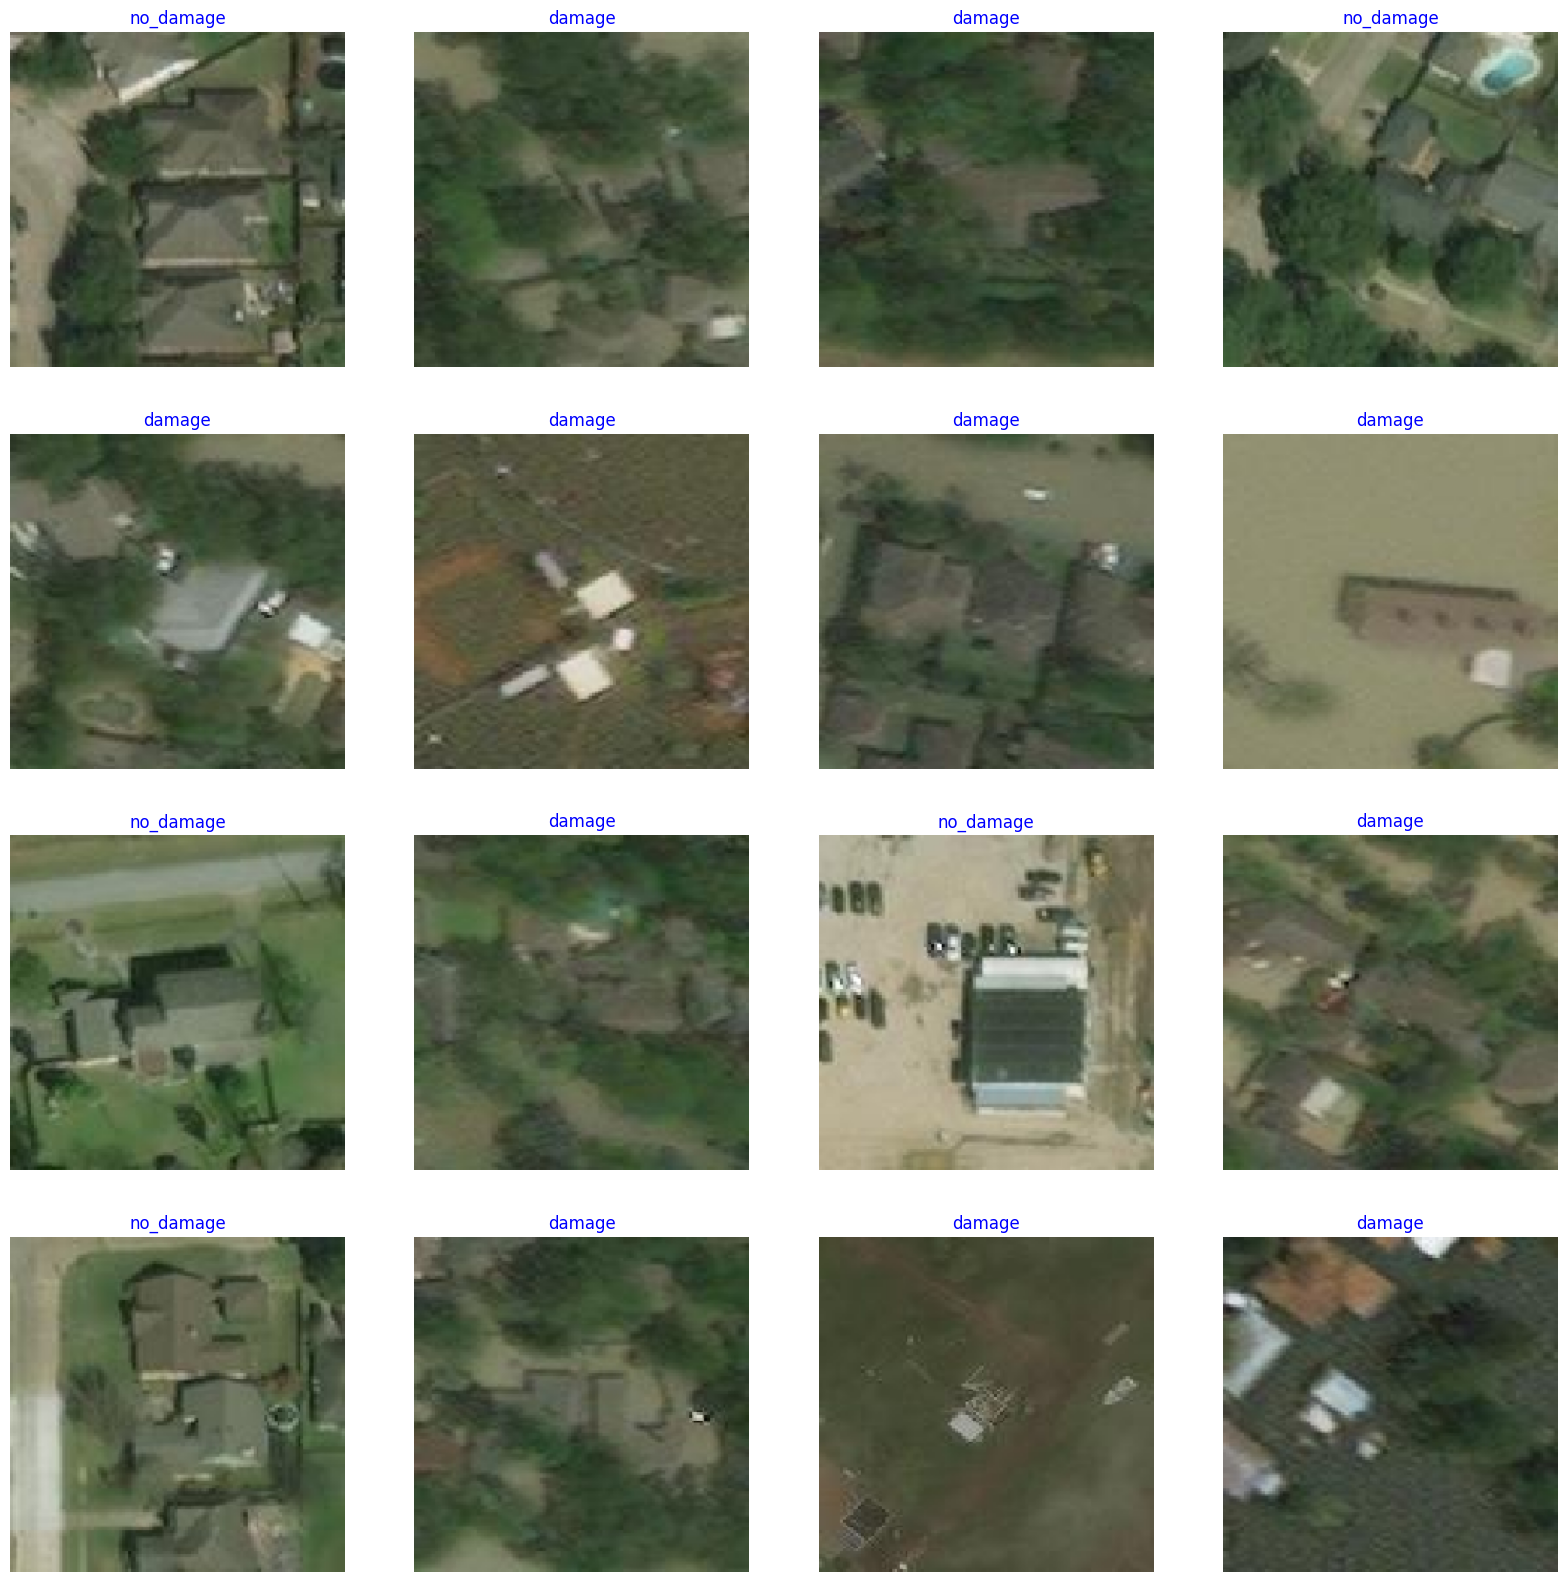

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Model Structure

**Generic Model Creation**

In [15]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
import tensorflow as tf

# Custom weights path
weights_path = '/kaggle/input/efficent90/tensorflow2/default/1/efficientnetb0_notop.h5'  # replace this path

base_model = EfficientNetB0(
    include_top=False,
    weights=weights_path,
    input_shape=(224, 224, 3),
    pooling='max'
)

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu',
          kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006)),
    Dropout(0.45),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("sucessful")

NameError: name 'class_count' is not defined

**Train model**

In [ ]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)


Epoch 1/20
625/625 [==============================] - 1605s 3s/step - loss: 3.2427 - accuracy: 0.9317 - val_loss: 1.2422 - val_accuracy: 0.9740
Epoch 2/20
625/625 [==============================] - 1555s 2s/step - loss: 0.6898 - accuracy: 0.9758 - val_loss: 0.3245 - val_accuracy: 0.9865
Epoch 3/20
625/625 [==============================] - 1550s 2s/step - loss: 0.2420 - accuracy: 0.9874 - val_loss: 0.1726 - val_accuracy: 0.9845
Epoch 4/20
138/625 [=====>........................] - ETA: 19:19 - loss: 0.1680 - accuracy: 0.9905

**Display model performance**

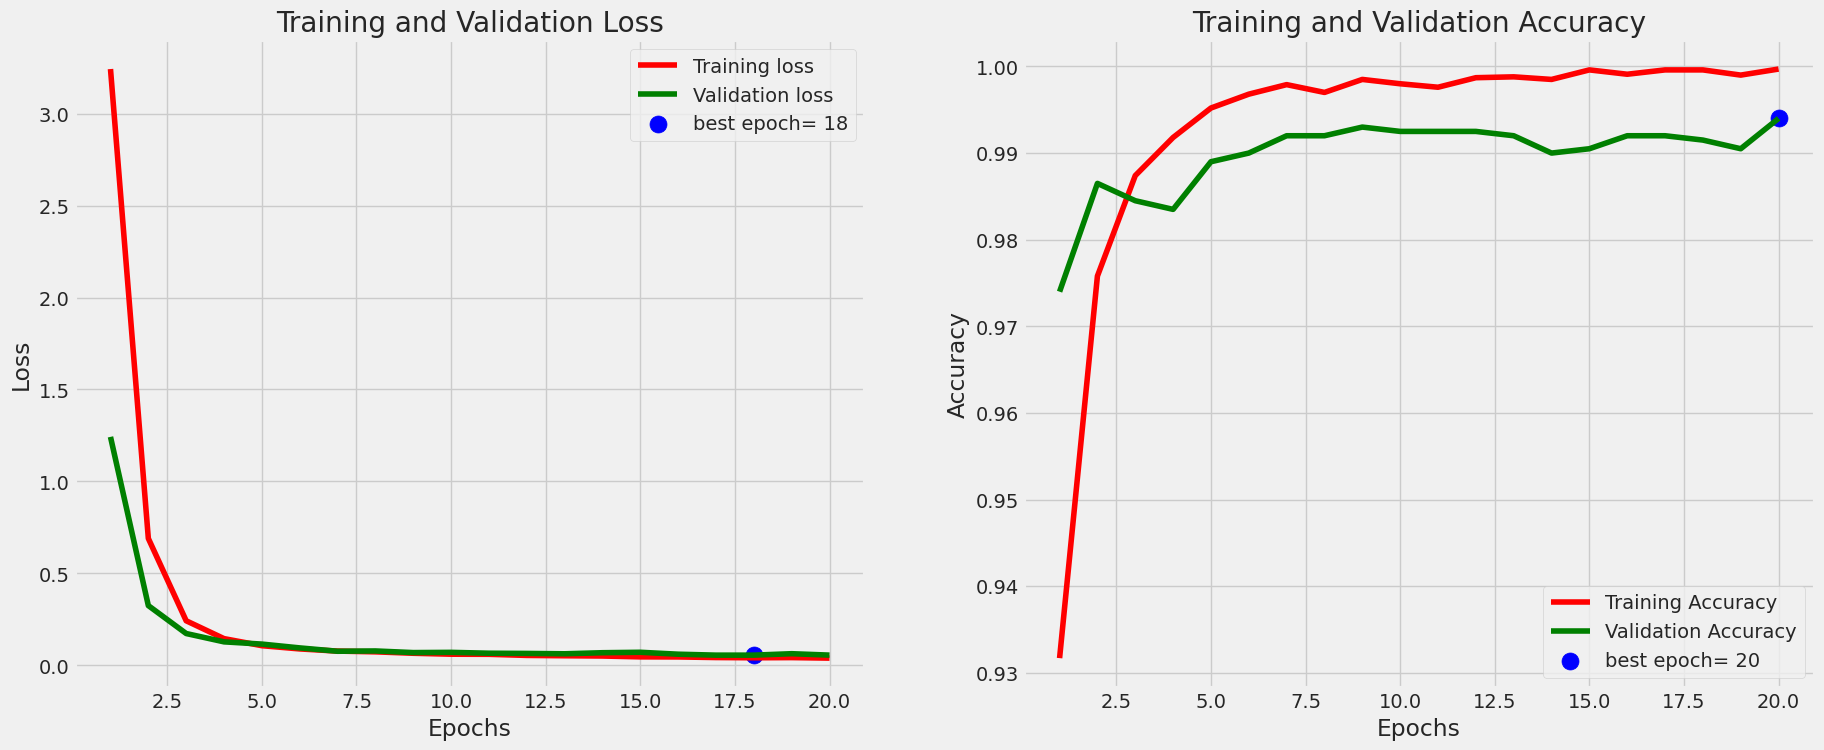

In [36]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

# Evaluate model

In [37]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

120/120 [==============================] - 68s 563ms/step - loss: 0.0500 - accuracy: 0.9964
Train Loss:  0.03128613531589508
Train Accuracy:  1.0
--------------------
Validation Loss:  0.056173309683799744
Validation Accuracy:  0.9937499761581421
--------------------
Test Loss:  0.05001102015376091
Test Accuracy:  0.9963541626930237


**Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Confusion Matrics and Classification Report**

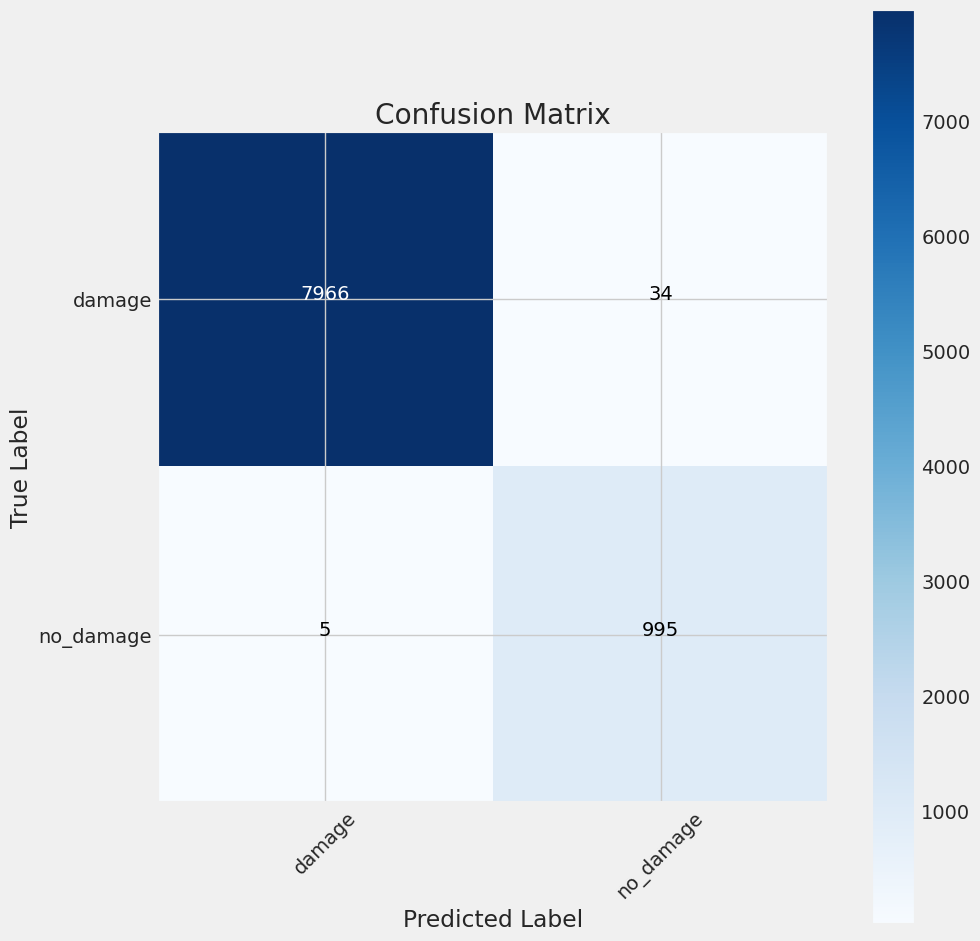

In [38]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [35]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      damage       1.00      1.00      1.00      8000
   no_damage       0.97      0.99      0.98      1000

    accuracy                           1.00      9000
   macro avg       0.98      1.00      0.99      9000
weighted avg       1.00      1.00      1.00      9000



**Save model**

In [ ]:
#Save the model
model.save('model.h5')

# Prediction using loaded_model

In [11]:
loaded_model = tf.keras.models.load_model('/kaggle/input/model99/tensorflow2/default/1/model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

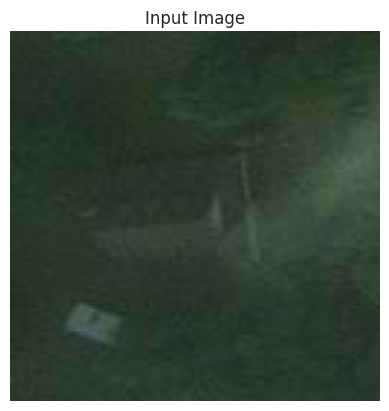

1/1 [==============================] - 0s 49ms/step
damage
Confidence: 73.09%


In [20]:
image_path = '/kaggle/input/satellite-images-of-hurricane-damage/test_another/damage/-93.53950999999999_30.982944.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Show the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.title("Input Image")
plt.show()

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
predicted_index = tf.argmax(score)

# Print predicted class and confidence
print(f"{class_labels[predicted_index]}")
print(f"Confidence: {score[predicted_index].numpy() * 100:.2f}%")


If you found it helpful, do upvote

Feel free to comment

I would love to have suggestions.